# MovieLens Recommendation with neural networks

## Постановка

**Задача**: на полном датасете [Movielens](https://grouplens.org/datasets/movielens/latest/) выучить векторные представления для пользователей и фильмов, чтобы можно было по вектору пользователя искать похожие представления фильмов и рекомендовать их ему.

In [1]:
import os
import random


import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.__version__

'2.0.1'

In [3]:
# trying to access env variables in cloud is pain
RANDOM_SEED=42
DATA_DIR="data/ml-latest"
OUTPUT_DIR="output"
MODEL_DIR="output/model"

In [4]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

## EDA

In [7]:
!ls data/raw/ml-latest

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


### Структура датасета

Датасет разделен на несколько содержательных таблиц

1. movies.csv - movieId,title,genres - список фильмов с присвоенными им жанрами
2. ratings.csv -  userId,movieId,rating,timestamp - список оценок, которые пользователи ставили фильмам
3. tags.csv - userId,movieId,tag,timestamp - список, пользовательских тегов, выставляемых фильмам
4. genome-scores.csv - содержит оценки релевантности пользовательских тегов
5. genome-tags.csv - tagId, tag - содрежит текстовые описания тегов

Из содеражния понятно, что таблица ratings.csv является основной, описывающей пользовательские взаимодействия. Остальные таблицы предоставляют сопровождающие мета-данные.
Рассмотрим распределения значений некоторых взаимодействий и данных.

In [12]:
movies_df = pd.read_csv(DATA_DIR + '/movies.csv')

In [14]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [60]:
# count all genres met
from collections import Counter
from itertools import chain

total_genres_list = list(chain(*[g_list.split('|') for g_list in movies_df['genres']]))
most_common_genres = Counter(total_genres_list).most_common()
genres, counts = list(zip(*most_common_genres))

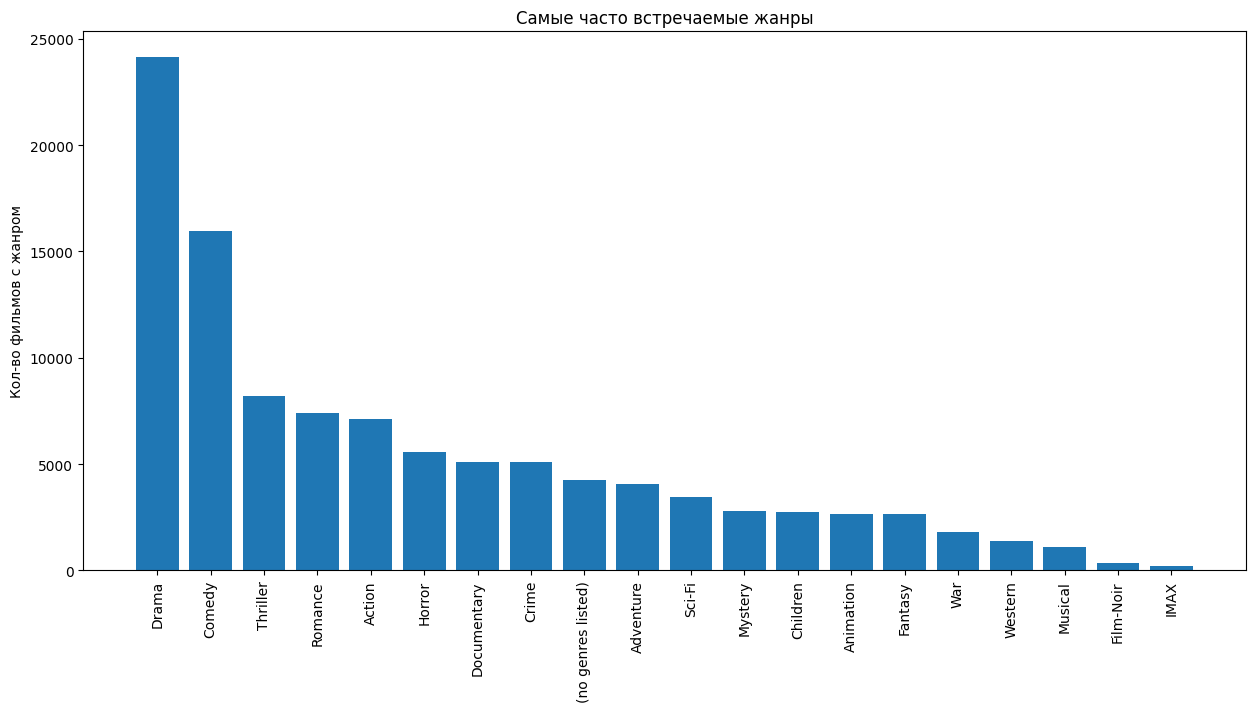

In [63]:
plt.figure(figsize=(15, 7))
plt.title("Самые часто встречаемые жанры")
plt.ylabel('Кол-во фильмов с жанром')
plt.bar(genres, counts)
plt.xticks(rotation='vertical')
plt.show()

Как видно из распределения, есть определенный баес в сторону небольшой группы жанров, что может повлиять на окончательный результат на полученных представлениях, которые могут получиться хуже и нерезпрезентативными на менее популярных жанрах, таких как IMAX, Film-Noir и т.п. 

In [10]:
# для удобства работы с данными заведем обертку для обраотки больших датасетов
def process_in_chunks(proc_func, merge_func, csv_file, chunksize=50_000):
    results = []
    for chunk in pd.read_csv(csv_file, chunksize=chunksize):
        results.append(proc_func(chunk))
    return merge_func(results)

In [15]:
from collections import Counter

def count_ratings(chunk):
    return Counter(chunk['rating'])


def merge_ratings(rating_counts):
    return sum(rating_counts, Counter())


rating_counts = process_in_chunks(
    count_ratings,
    merge_ratings,
    DATA_DIR + "/ratings.csv"
)

Counter({3.5: 3404360,
         1.5: 441354,
         4.5: 2373550,
         2.5: 1373419,
         4.0: 7394710,
         3.0: 5515668,
         2.0: 1850627,
         5.0: 4071135,
         1.0: 886233,
         0.5: 442388})

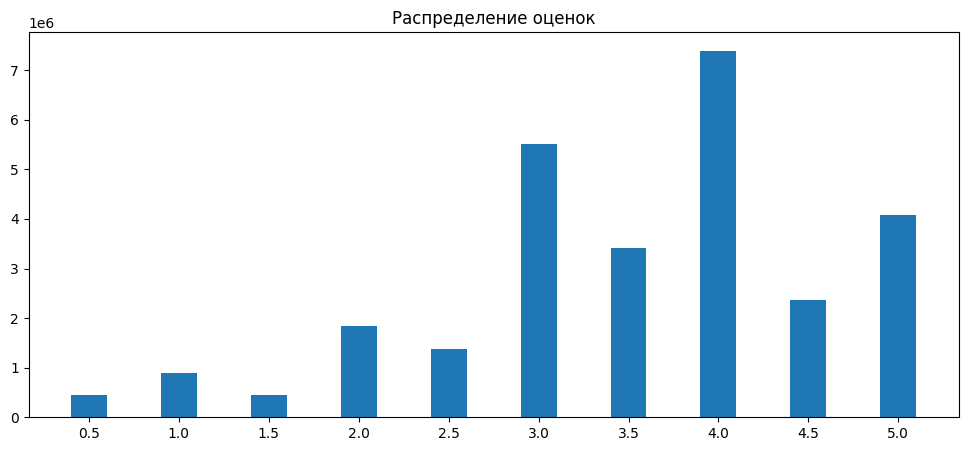

In [34]:
plt.figure(figsize=(12, 5))
labels, counts = list(zip(*[(v, rating_counts[v] ) for v in sorted(rating_counts.keys())]))
plt.title("Распределение оценок")
plt.bar([str(l) for l in labels], counts, align='center', width=0.4)
plt.show()

Как видим распределение оценок смещено вправо к самой нейтральной оценке 4, что ожидаемо с точки зрения человеческой реакции. Также можно видеть, что фильмам редко ставят низкие оценки, гораздо реже, чем крайне положительные. Это объясняется тем, что чем более низкий рейтинг, тем меньше людей рискнет его посмотреть, поэтому такие фильмы должны быть в среднем менее популярны (а учитывая, что люди часто ориентируются на топы, это различие только усиливается со временем). 

К сожалению, у нас нет какого-то implicit фидбека вроде просмотров, поэтому проверить это наверняка не получится, но это наиболее простое объяснение.

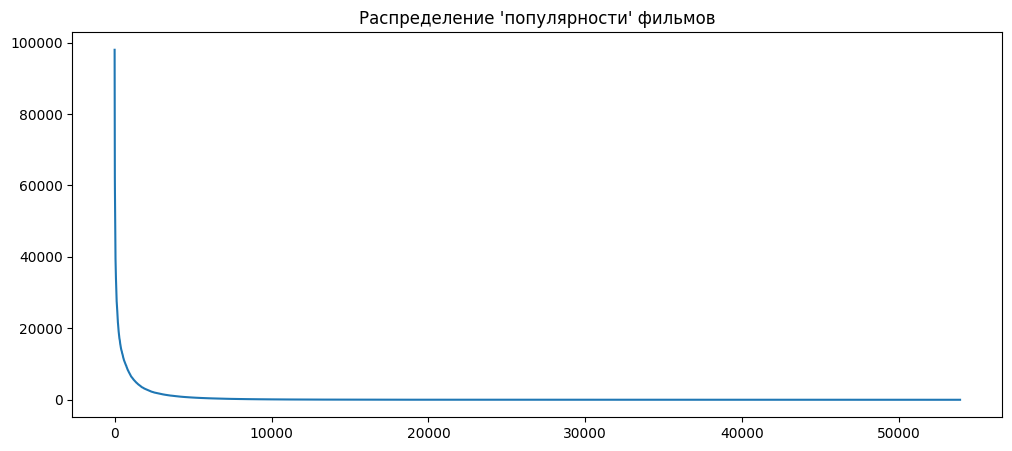

In [46]:
def count_movie_interactions(chunk):
    return Counter(chunk['movieId'])


def merge_counts(movie_counts):
    return sum(movie_counts, Counter())


movie_counts = process_in_chunks(
    count_movie_interactions,
    merge_counts,
    DATA_DIR + "/ratings.csv"
)

plt.figure(figsize=(12, 5))
_, counts = list(zip(*movie_counts.most_common()))
plt.title("Распределение 'популярности' фильмов")
plt.plot(counts)
plt.show()

Как видно из графика, пользователи активно взаимодействуют с очень небольшой долей фильмов.

In [39]:
# на всякий случай устроим контрольную проверку на пропуски во всех табличках (даже если не все будем использовать)
import glob

ds_files = glob.glob(DATA_DIR + "/*.csv")

def count_nans(chunk):
    return chunk.isna().sum() 


def merge_counts(nan_counts):
    return sum(nan_counts)


for f in ds_files:
    nan_count = process_in_chunks(count_nans, merge_counts, f)
    print(f'NaN count in {f}\n{nan_count}')
    

NaN count in data/ml-latest/ratings.csv
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
NaN count in data/ml-latest/tags.csv
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
NaN count in data/ml-latest/links.csv
movieId      0
imdbId       0
tmdbId     181
dtype: int64
NaN count in data/ml-latest/movies.csv
movieId    0
title      0
genres     0
dtype: int64
NaN count in data/ml-latest/genome-tags.csv
tagId    0
tag      0
dtype: int64
NaN count in data/ml-latest/genome-scores.csv
movieId      0
tagId        0
relevance    0
dtype: int64


В данных есть пропуски (не указаны ссылки на внешние ресурсы и иногда нет пользовательских тегов), но они несущественные для датасета такого размера, так что можно просто проигнорировать.

## Предобработка данных

Теперь, когда мы представляем устройство данных. Подготовим нужное для дальнейшей работы.

1. Из ratings.csv извлечем информацию о взаимодействиях пользователей и фильмов
2. Сложим все мета-данные по фильмам в одну таблицу (потом еще с ними будем работать)
3. Не будем учитывать неактивных пользователей и фильмов - их вклад в информационное наполнение значительно меньше, от него можно избавиться

По пользователям особо нет мета-данных, кроме времени активности (timestamp у каждого взаимодействия), которое можно использовать для обуславливания на различные паттерны вроде времени суток, дней недели и т.п. Возможно, если останется время для улучешний, вернемся к этим данным (как я понял, на практике именно время дает существенный прирост качества).

In [ ]:
def preprocess_data(ratings_df, user_thresh=0.1, movie_thresh):
    user_ids = ratings_df.groupby
    


class UserItemRatingsDataset(Dataset):
    def __init__(self):
        self.num_of_users = 0
        self.num_of_items = 0
        
    
    def __getitem__(self, idx):
        u_idx = self.idx // self.num_of_users
        i_idx = self.idx % self.num_of_users
        return (torch.tensor([self.user_ids[u_idx]]), torch.tensor([self.item_ids[i_idx]]), self.ratings[idx]
    
    def __len__(self):
        reutrn len(self.ratings)

## Валидация и выборка

Используем train/val/test сплит. При сплите гарантируем, что пользователь есть во всех сплитах. На метрики при обучени будем смотреть на train/val, итоговое качество определим на отложенной выборке test.

Каким образом оценивать "хорошесть" полученных векторов? Из всего материала, что я прочитал, примерный самый адекватный подход
- обучить модель векторизации на какую-то прокси метрику
- полученные представления передать ранжирующей модели и посмотреть, как измениться качество с точки зрения целевых метрик (а ранжирующие метрики - самые информативные).

В качестве прокси-метрики удобно использовать **MSE**/**RMSE** при обучении модели предсказывать оценку пользователя фильму. Но это только прокси-метрика, она не дает представления, насколько хороши полученные векторы.

С одной стороны, MoviLens датасет не предоставляет разметки данных, позволяющих определить относительную меру релевантности для конкретных предсказаний. Если следовать этой логике, хорошесть векторов можно оценивать только в совокупности, неплохие метрики для этого - Recall@k, Precision@k и их усредненние для всех предсказаний: MAR@K, MAP@k. Считать их можно просто с точки зрения
того, ставил им пользователь оценку или нет.

$$
Precition(k) = \frac{|\{ relevant ~ movies \} \cap \{ recommended ~ k ~ movies \} |}{|\{ recommended ~ k ~ movies \}|}
\\ Recall(k) = \frac{|\{ relevant ~ movies \} \cap \{ recommended ~ k ~ movies \} |}{\{ relevant ~ movies \}}
$$


С другой стороны, такая мера релевантности есть - это оценка пользователя фильма. Поэтому было классно ориентироваться на метрику, которая приоритизирует фильмы с позитивной оценкой перед негативными.
Интуиция такая: если пользователь посмотрел и поставил положительную оценку, это всегда лучше, чем если он посмотрел и поставил негативную или вовсе не посмотрел (мы же хотим рекомендовать те фильмы, которые ему нравятся, а не любые, но это вопрос дискуссионный, надо смотреть на бизнес-метрики :)).

С этой точки зрения можно смотреть на метрику nDCG@k, учитывающую нормализованное суммарное накопление рейтингов пользователя со штрафом за порядок.

$$
NCDG(k) = \frac{DCG(k)}{IDCG(k)} \\ DCG(k)  = \sum^{k}_{i=1} \frac{G_i}{log_2(i + 1)} \\ IDCG(k)  = \sum^{|I(k)|}_{i=1} \frac{G_i}{log_2(i + 1)} 
$$

In [20]:
def Precision(y_true, y_pred, k):
    if k > y_true.shape[0]:
        k = y_true.shape[0]
    y_true = y_true[:k]
    y_pred = y_pred[:k]
    y_true = (y_true > 0).astype('int')
    y_pred = (y_true > 0).astype('int')
    
    recall = np.sum(y_true * y_pred) * 1.0 / np.sum(y_pred)


def Recall(y_true, y_pred, k):
    if k > y_true.shape[0]:
        k = y_true.shape[0]
    y_true = y_true[:k]
    y_pred = y_pred[:k]
    y_true = (y_true > 0).astype('int')
    y_pred = (y_true > 0).astype('int')
    
    recall = np.sum(y_true * y_pred) * 1.0 / np.sum(y_true)

    
def MAP(y_true, y_pred, k):
    """Mean Average Precision - calculates average precision over all user predictions
    
    y_true - true matrix of user ratings
    y_pred - predicted matrix of user ratings
    
    """
    psum = 0.
    n = len(y_pred.shape[0])
    for i in range(n):
        psum += Precision(y_true[i], y_pred[i], k)
    return psum / n


def MAR(y_true, y_pred, k):
    rsum = 0.
    n = len(y_pred.shape[0])
    for i in range(n):
        rsum += Recall(y_true[i], y_pred[i], k)
    return rsum / n
    

def NCDG(y_true, y_pred, k):
    """
    Normalized Discounted Cumulative Gain
    
    Parameters:
    y_true - true scores for all movies for user
    y_pred - predicted scores for all movies for user
    k - up to what position calculate
    """
    if k > y_true.shape[0]:
        k = y_true.shape[0]
    idx = np.flip(np.argsort(y_pred)) # order by relevance in predictions
    true_idx = np.flip(np.argsort(y_true)) # order by relevance in true labels
    dcg = 0.
    idcg = 0.
    for i in range(1, k + 1):
        dcg += y_pred[idx[i]] / np.log(i + 1)
        idcg += y_true[true_idx[i]] / np.log(i + 1)
    return dcg/idcg
            

def MNCDG(y_true, y_pred, k):
    dcg_sum = 0.
    n = len(y_pred.shape[0])
    for i in range(n):
        dcg_sum += NDCG(y_true[i], y_pred[i], k)
    return dcg_sum / n


Метрики готовы

##  Model

## Collabarative only - NCF

Одним из первых нейросетевых подходов, попытавшихся делать коллабаративную фильтрацию с помощью нейронных сетей, был Neural Collaborative Filtering. Идея очень простая - заменить скалярное произведение в матричной факторизации на обучающуюся нейлиную операцию. Таргет такой же, как и в обычной матричной факторизации - минимизация MSE предсказываемого рейтинга (в оригинальной статье у них был implicit feedback и бинарная кросс-энтропия, но у нас другая задача).

In [ ]:
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_of_users, num_of_items, hiddim):
        self.num_of_users = num_of_users
        self.num_of_items = num_of_items
        self.hiddim = hiddim
        self.user_embeddings = nn.Embedding(num_of_users, hiddim)
        self.movie_embeddings = nn.Embedding(num_of_items, hiddim)
        
        self.ncf = nn.Sequential(
            nn.Linear(hiddim*2, hiddim),
            nn.ELU(),
            nn.Linear(hiddim, hiddim//2),
            nn.Dropout(0.2)
            nn.ELU(),
            nn.Linear(hiddim//2, 1),
            nn.Sigmoid() # normalize between 0 and 1
        )
    
    def forward(self, uid, iid):
        u_onehot = F.one_hot(uid, self.num_of_users)
        i_onehot = F.one_hot(iid, self.num_of_items)
        
        user_embeds = self.user_embedding(u_onehot)
        item_embeds = self.item_embedding(i_onehot)
        
        outp = self.ncf(torch.cat((user_embeds, item_embeds), dim=1))
        return outp * 5 # [0, 1] -> [0, 5]
        

In [ ]:
from tqdm import tqdm
from statistics import mean

def plot_train_hist(loss_hist, metrics_hist):
    train_loss_hist, val_loss_hist = list(zip(*loss_hist))
    metrics_hist = list([list(m.values()) for m in metrics_hist])
    prec_hist, recall_hist, ndcg_hist = list(zip(*metrics_hist))
    metrics_labels = list(metrics_hist[0].keys())
    
    _, axs = plt.subplots(1, 2, figsize=(12, 7))
    axs[0].plt(train_loss_hist, label='train_loss')
    axs[0].plt(val_loss_hist, label='val_loss')
    axs[0].legend()
    
    axs[1].plt(prec_hist, label=metrics_labels[0])
    axs[1].plt(recall_hist, label=metrics_labels[0])
    axs[1].plt(prec_hist, label=metrics_labels[0])
    axs[1].legend()
    
    plt.suptitle("Результат обучения")
    ptt.show()
    

@torch.no_grad()
def evaluate_model(model, loader):
    """Isolated evaluation function, used for test set"""
    y_true = [], y_pred = []
    for (user_ids, movie_ids), r in loader:
            user_ids = user_ids.to(device)
            movie_ids = movie_ids.to(device)
            r = r.to(device)
            with torch.no_grad():
                r_pred = model(user_ids, movie_ids)
            y_true.append(r.cpu().numpy())
            y_pred.append(r_pred.cpu().numpy())
    prec = MAP(y_true, y_pred, 10)
    recall = MAR(y_true, y_pred, 10)
    ndcg = MNCDG(y_true, y_pred, 10)
    
    print("Quality on test\nMAP@10: {prec:.4f}\nMAR: {recall:.4f}\nMNDCG: {ndcg:.4f}"


def train_ncf(model, criterion, optimizer_type, optimizer_kwargs, tr_loader, val_loader, max_epochs=30, tol=5):
    optimizer = optimizer_type(model.parameters(), **optimizer_kwargs)
    loss_hist = []
    best_loss = float('inf')
    metrics_hist = []
    t = tol
    logmes = "epoch {}# train_loss {}, val_loss {:.4f}, val_precision: {:.4f}, val_recall: {:.4f}, val_ndcg: {:.4f}"
    
    for epoch in (pbar := tqdm(range(epoch_num)):
        if t == 0:
            print("Early stop, reached tolerance lebel!\n\n"
            break    
        # train epoch
        model.train()
        tr_losses = []
        for (user_ids, movie_ids), r in tr_loader:
            optimizer.zero_grad()
            
            user_ids = user_ids.to(device)
            movie_ids = movie_ids.to(device)
            r = r.to(device)
            
            r_pred = model(user_ids, movie_ids)
            loss = criterion(r_pred, r)
            tr_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
        
        tr_loss = mean(tr_losses)
        if tr_loss < best_loss:
            best_loss = tr_loss
            t = tol
        else:
            t -= 1
                     
        # eval epoch
        model.eval()
        val_losses = []
        val_metrics = {}
        y_true = [], y_pred = []
        for (user_ids, movie_ids), r in tr_loader:
            
            user_ids = user_ids.to(device)
            movie_ids = movie_ids.to(device)
            r = r.to(device)
            with torch.no_grad():
                r_pred = model(user_ids, movie_ids)
                loss = criterion(r_pred, r)
            val_losses.append(loss.item())
            y_true.append(r.cpu().numpy())
            y_pred.append(r_pred.cpu().numpy())
        
        val_loss = mean(val_losses)
        val_metrics['MAP@10'] = MAP(y_true, y_pred, 10)
        val_metrics['MAR@10'] = MAR(y_true, y_pred, 10)
        val_metrics['MNDCG@10'] = MNCDG(y_true, y_pred, 10)    
        
        loss_hist.append((tr_loss, val_loss))
        metrics_hist.append(val_metrics)
        
        log = log_message.format(e, loss_hist[-1][0], loss_hist[-1][1], *list(val_metrics.values()))
        pbar.set_description(log)
        
    
    del optimizer
    torch.cuda.empty_cache()
    gc.collect()
    return loss_hist, metrics_hist

In [ ]:
# test output and correctness

## Training and evaluation

### NCF

In [ ]:
model = NCF(
    
)

criterion = nn.MSE()

optimizer_type = torch.optim.Adam
optimizer_kwargs = {
    'lr': 3e-4
}

In [ ]:
hist = train_ncf(
    model, 
    criterion, 
    optimizer_type, 
    optimizer_kwargs, 
    tr_loader, 
    val_loader, 
    max_epochs=30, 
    tol=5
)

In [ ]:
plot_train_hist(*hist)

In [ ]:
evaluate_model(model, test_loader)

## Анализ результатов